# Fine dust prediction (하루 평균 미세 먼지 수치 예측)
Training convolutional recurrent network to predict fine-dust.

pm10 단위의 하루 평균 미세 먼지 수치를 예측하기 위해 CRNN 을 훈련시킵니다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
LOCATION_CNT = 39
BOROUGH_CNT = 25
WEEKLY_BATCH = 7

TEST_SIZE = 15
TRAIN_SIZE = 240
BATCH_SIZE = 40

TRAIN_ITER = 200
BATCH_ITER = TRAIN_SIZE // BATCH_SIZE

## Pre-processing data
Pre-processing the daily average amount of the fine dust(pm10) to bundle it in 7 days.

For the convolution layer, the amount of fine dust for each region is mapped to the geographical map of Seoul. 

The data was extracted from the csv file [Seoul Daily Average Air Pollution Degree Information](http://data.seoul.go.kr/openinf/sheetview.jsp?infId=OA-2218&tMenu=11) provided by the Seoul Open Data Plaza.

하루 평균 미세 먼지 수치를 7일 단위로 전처리 합니다.

convolution layer를 위해, 지역별 미세 먼지 수치는 실제 서울시 지도에 대응됩니다. (seoul_map)

데이터는 서울 열린 데이터 광장에서 제공하는 [서울시 일별 평균 대기 오염도 정보](http://data.seoul.go.kr/openinf/sheetview.jsp?infId=OA-2218&tMenu=11) csv 파일에서 추출하였습니다. 

In [3]:
csv_name = 'MonthlyAverageAirPollutionInSeoul.csv'

seoul_map = [ # 9 by 8 matrix, 25 borough
    [0, 0, 0, 0, '도봉구', '노원구', 0, 0],
    [0, 0, 0, '강북구', '강북구', '노원구', '노원구', 0],
    [0, '은평구', '종로구', '성북구', '성북구', '성북구', '중랑구', 0],
    [0, '은평구', '서대문구', '종로구', '종로구', '동대문구', '중랑구', 0],
    [0, '은평구', '서대문구', '서대문구', '중구', '성동구', '광진구', '강동구'],
    [0, '마포구', '마포구', '마포구', '용산구', '강남구', '송파구', '강동구'],
    ['강서구', '강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', 0],
    [0, '양천구', '영등포구', '관악구', '서초구', '강남구', '송파구', 0],
    [0, '구로구', '금천구', '관악구', '서초구', 0, 0, 0]
]

In [4]:
def read_csv(name):
    """Read the csv file and return the amount of fine dust for each region grouped by date.
    
    Args:
        name: The name of the csv file to read.
    
    Returns:
        Dictionary object mapping the amount of fine dust per zone by date.
        {'20170506': {'강남구': 50, '강동구': 60, '강서구':70}, '20170507': {'강남구': } ...}
    
    Raises:
        ValueError: If the number of data per day in the csv file is not equal to LOCATION_CNT.
        
    """
    with open(name) as f:
        raw_data = f.read().strip()

    del_quote = raw_data.replace("\"", '')
    data = list(map(lambda x: x.split(','), del_quote.split('\n')))[1:] # [1:] csv header

    splitted = []

    ptr = 0
    for i in range(len(data) // LOCATION_CNT):
        splitted.append(data[ptr:ptr+LOCATION_CNT])
        ptr += LOCATION_CNT
    
    ## test case
    for date_list in splitted:
        date = date_list[0][0] # index 0:date
        for local in date_list:
            if date != local[0]:
                raise ValueError(date + ' is not same as ' + 'local[0]')
    
    def filter_borough(dic):
        return dict(filter(lambda t: '구' in t[0], dic.items())) #filter not road name only borough 

    # index 0:date, 1:local name, 6:pms
    pms = dict(map(lambda x: (x[0][0], dict(map(lambda t: (t[1], t[6]), x))), splitted))
    pms_filtered = dict(filter(lambda x: '' not in x[1].values(), pms.items())) # csv data contains spaces
    pms_filtered2 = dict(map(lambda x: (x[0], filter_borough(x[1])), pms_filtered.items()))
    
    return pms_filtered2

In [5]:
def geographical_mapping(pms_data):
    """Map the amount of fine dust for each region to geographical map of Seoul.
    
    Args:
        pms_data: Fine dust data pre-processed by read_csv.
            Dictionary obejct mapping the amount of fine dust per area by date.
            {'20170506': {'강남구': 50, '강동구': 60, '강서구':70}, '20170507': {'강남구': } ...}
    
    Returns:
        dict that map the amount of fine dust to the geographical map of Seoul.
        {'20170506': [[0, 0, 0, 0, 50, 60, 0, 0], [0, 0, 0, 40, ...]]}
      
    """
    def dict2seoul(p):
        return list(map(lambda t: list(map(lambda x: int(p[x]) if x != 0 else 0, t)), seoul_map))

    # map dict to seoul geographic map
    pms_mapped = dict(map(lambda p: (p[0], dict2seoul(p[1])), pms_data.items())) 
    return pms_mapped

In [6]:
def generate_dataset(data):
    """ Generate the daily average amount of the fine dust(pm10) bundled in 7 days.
    
    Args:
        data: Fine dust data pre-processed by read_csv
            Dictionary object mapping the amount of fine dust per area by date.
            {'20170506': {'강남구': 50, '강동구': 60, '강서구':70}, '20170507': {'강남구': } ...}
    
    Returns:
        pms_sampled: the amount of fine dust bundled in 7 days.
        pms_result: the amount of fine dust on the next day.
        
    """
    pms_mapped = geographical_mapping(data)
    
    # tie data to WEEKLY_BATCH(7) batches
    pms_data = list(map(lambda x: x[1], sorted(pms_mapped.items()))) 
    pms_sampled = list(map(lambda i: pms_data[i:i+WEEKLY_BATCH], range(len(pms_data) - WEEKLY_BATCH - 1)))
    
    pms_result = list(map(lambda x: list(map(lambda t: t[1], sorted(x[1].items()))), sorted(data.items())))
    pms_result = pms_result[WEEKLY_BATCH+1:]
    
    return pms_sampled, pms_result

In [7]:
pms_data = read_csv(csv_name)
pms_sampled, pms_result = generate_dataset(pms_data)

In [8]:
test_sampled = pms_sampled[-TEST_SIZE:]
test_result = pms_result[-TEST_SIZE:]

data_set = list(zip(pms_sampled[:-TEST_SIZE], pms_result[:-TEST_SIZE]))
np.random.shuffle(data_set)

train_set, cv_set = data_set[:TRAIN_SIZE], data_set[TRAIN_SIZE:]

train_sampled = list(map(lambda x: x[0], train_set))
train_result = list(map(lambda x: x[1], train_set))

cv_sampled = list(map(lambda x: x[0], cv_set))
cv_result = list(map(lambda x: x[1], cv_set))

## Generate Model
Generate convolutional recurrent networks to predict fine-dust.

Convolution each layer separately with 3x3 sized, 1x16, 16x32, 32x64 filter.

Flatten each layer and pass it to the recurrent unit, 2048 hidden units.

Calculate estimates via three fully connected layer (2048, 512, 25).

Optimize it with square mean error, RMSPropOptimizer.

<img src="https://github.com/revsic/Fine-Dust-Prediction/raw/master/network_model.png" width="60%" align="left">

In [9]:
def lrelu(layer):
    """Implementation of leaky relu, leak 0.2.
    
    Args:
        layer: tensor which lrelu will be applied.
        
    Returns:
        Tensor which lrelu is applied.
    
    """
    return tf.maximum(0.2*layer, layer)


def batch_norm(x, name='batch_norm'):
    """Alias of tf.contrib.layers.batch_norm.
    
    Args:
        x: tensor which batch normalization will be applied.
        
    Returns:
        Tensor which batch normalization is applied.
    
    """
    return tf.contrib.layers.batch_norm(x,
                                        decay=0.9, 
                                        updates_collections=None,
                                        epsilon=1e-5,
                                        scale=True,
                                        is_training=True,
                                        scope=name)

In [10]:
X = tf.placeholder(tf.float32, [None, WEEKLY_BATCH, 9, 8]) # matrix size [9, 8]
Y = tf.placeholder(tf.float32, [None, BOROUGH_CNT])

Xt = tf.transpose(X, [1, 0, 2, 3])

In [11]:
reused = False

def layer2conv(layer):
    """Convolution and flatten layer with 3x3 sized 1x16, 16x32, 32x64 conv2d filter.
    
    To use the same filter but convolute the layers seperately, `layer2conv` use variable_scope.
    It use `reused` as False only one time, then set True after all.
    The same filter will applied to all layer, but we can convolute it seperately.
    
    Args:
        layer: Tensor shaped [-1, 9, 8] which Conv2D will be applied.
    
    Returns:
        Tensor shaped [-1, 9*8*64] which convolution filter[1x16, 16x32, 32x64] is applied.
    
    """
    
    global reused
    
    with tf.variable_scope('conv_layer', reuse=reused):
        w1 = tf.get_variable('w1', [3, 3, 1, 16],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        w2 = tf.get_variable('w2', [3, 3, 16, 32],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        w3 = tf.get_variable('w3', [3, 3, 32, 64],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        layerT = tf.reshape(layer, [-1, 9, 8, 1])
        
        l1 = tf.nn.conv2d(layerT, w1, strides=[1, 1, 1, 1], padding='SAME')
        l1 = lrelu(batch_norm(l1, name='l1_norm'))
        
        l2 = tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME')
        l2 = lrelu(batch_norm(l2, name='l2_norm'))
        
        l3 = tf.nn.conv2d(l2, w3, strides=[1, 1, 1, 1], padding='SAME')
        l3 = lrelu(batch_norm(l3, name='l3_norm'))
        
        l3_reshaped = tf.reshape(l3, [-1, 9 * 8 * 64]) # flatten conv layer
    
    reused = True
    return l3_reshaped

conv = [layer2conv(Xt[i]) for i in range(WEEKLY_BATCH)]
convT = tf.transpose(conv, [1, 0, 2])

In [12]:
lstm_cell = tf.contrib.rnn.LSTMCell(2048)
out, state = tf.nn.dynamic_rnn(lstm_cell, convT, dtype=tf.float32)

l4 = tf.transpose(out, [1, 0, 2])[-1]
l4 = batch_norm(l4, name='l4_norm')

In [13]:
w4 = tf.get_variable('w4', shape=[2048, 1024],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
w5 = tf.get_variable('w5', shape=[1024, 512],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))
w6 = tf.get_variable('w6', shape=[512, BOROUGH_CNT],
                    initializer=tf.truncated_normal_initializer(stddev=0.02))

l5 = batch_norm(tf.matmul(l4, w4),  name='l5_norm')
l5 = lrelu(l5)

l6 = batch_norm(tf.matmul(l5, w5), name='l6_norm')
l6 = lrelu(l6)

l7 = batch_norm(tf.matmul(l6, w6), name='l7_norm')
l7 = tf.nn.relu(l7)

pred = l7

loss = tf.reduce_mean(tf.square(Y - pred))
opt = tf.train.RMSPropOptimizer(0.1).minimize(loss)

## Training

Train CRNN Networks with batch size 40, train iter 200.

Record training and cross validation errors during training.

CRNN 네트워크를 학습시킵니다. batch 크기는 40개, 반복 횟수는 200번입니다.

훈련 과정에서 training error 와 cross validation error 을 계산, 기록합니다.

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
train_loss = []
cv_loss = []

for i in range(TRAIN_ITER + 1):
    ptr = 0
    for _ in range(BATCH_ITER):
        _, trainloss = sess.run([opt, loss], feed_dict={X: train_sampled[ptr:ptr+BATCH_SIZE], 
                                                       Y: train_result[ptr:ptr+BATCH_SIZE]})
        
        cvloss = sess.run(loss, feed_dict={X: cv_sampled, Y: cv_result})
        
        ptr += BATCH_SIZE

    train_loss.append(trainloss)
    cv_loss.append(cvloss)
    
    if i % (TRAIN_ITER // 10) == 0:
        print(i/TRAIN_ITER, cvloss)

0.0 2288.19
0.1 1193.11
0.2 609.496
0.3 1266.76
0.4 344.85
0.5 468.753
0.6 506.217
0.7 447.375
0.8 354.178
0.9 336.421
1.0 277.538


## Visualization

Visualize loss graph and actual value and estimates for the test set.

loss graph 와 test set 에 대한 실제 값과 평가치를 시각화합니다.

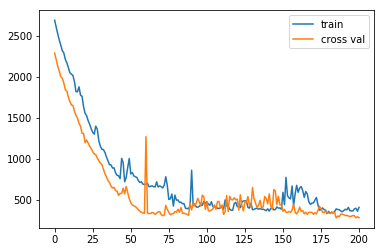

In [16]:
plt.plot(train_loss, label='train')
plt.plot(cv_loss, label='cross val')
plt.legend()

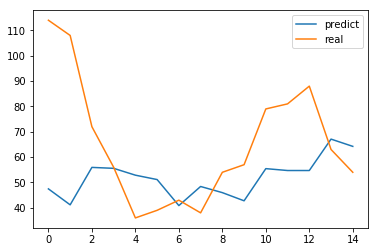

In [17]:
predict = sess.run(pred, feed_dict={X: test_sampled})
pred_gangnam = list(map(lambda x: x[0], predict))
real_gangnam = list(map(lambda x: x[0], test_result))

plt.plot(pred_gangnam, label='predict')
plt.plot(real_gangnam, label='real')
plt.legend()

In [18]:
sess.close()

## Conclusion

Unfortunately, learning did not work out better than I thought.

In addition to the fine-dust, the accuracy can be improved by adding wind direction or date information.

안타깝게도, 학습이 생각보다 잘 이루어지지 않았습니다.

하루 평균 미세 먼지 양 이외에도 풍향이나 날짜 정보를 추가하여 정확도를 높일 수 있을 것으로 보입니다.